In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from timm.models.helpers import load_pretrained
from tqdm import tqdm

from models.t2t_vit import t2t_vit_14
from vit_shapley.modules.surrogate import Surrogate
from vit_shapley.CIFAR_10_Dataset import CIFAR_10_Dataset, CIFAR_10_Datamodule, PROJECT_ROOT, apply_masks_to_batch

if torch.cuda.device_count() > 1:
    torch.cuda.set_device(5)

In [2]:
datamodule = CIFAR_10_Datamodule(num_players=196, num_mask_samples=1, paired_mask_samples=False)
datamodule.setup()
data = next(iter(datamodule.train_dataloader()))

images = data['images']
labels = data['labels']
masks = data['masks']
print(images.shape, labels.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32, 1, 196])


<font size="12">Target model visualization</font>

In [3]:
from utils import load_checkpoint
target_model = t2t_vit_14(num_classes=10)
# target_model_path = PROJECT_ROOT / "saved_models/downloaded/cifar10/cifar10_t2t-vit_14_98.3.pth"
target_model_path = PROJECT_ROOT / "saved_models/transferred/cifar10/ckpt_0.01_0.0005_97.5.pth"
load_checkpoint(target_model_path, target_model, device="cuda")
target_model.eval()

# Predict with the model.
logits = target_model(images.cuda())
print(f'logits shape is {tuple(logits.shape)}')
preds = torch.argmax(logits, dim=1)

adopt performer encoder for tokens-to-token


logits shape is (32, 10)


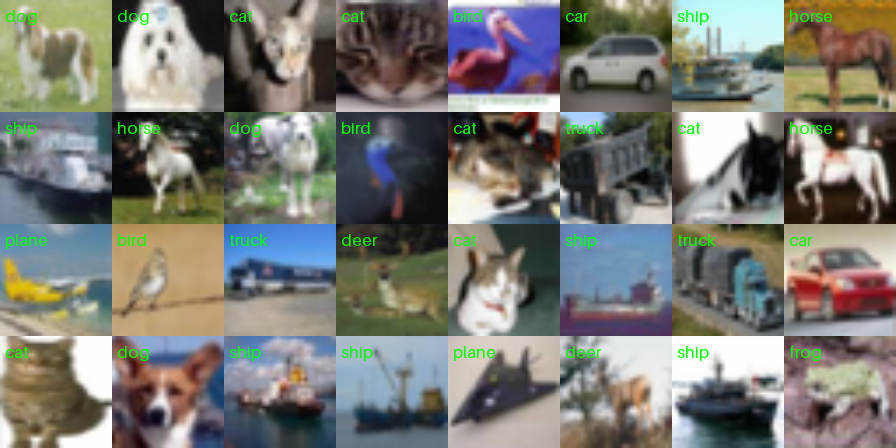

In [4]:
colors = [(0, 255, 0) if l == p else (255, 0, 0) for l, p in zip(labels, preds)]
CIFAR_10_Dataset.to_image_grid(images, preds, colors, scale=1/2)

In [5]:
def test_without_masks(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, device="cuda") -> None:
    with torch.no_grad():
        model.to(device)
        correct, total = 0, 0
        progress = tqdm(dataloader)
        for d in progress:
            images, targets, masks = d['images'], d['labels'], d['masks']
            images, targets = images.to(device), targets.to(device)
            logits = model(images)
            _, predicted = logits.max(dim=1)
            total += targets.shape[0]
            correct += predicted.eq(targets).sum().item()
            progress.set_description(f'Accuracy: {100.0 * correct / total:.2f}%')

test_without_masks(target_model, datamodule.test_dataloader(), "cuda")

Accuracy: 97.50%: 100%|██████████| 313/313 [00:15<00:00, 19.86it/s]


<font size="12">Surrogate model visualization</font>

In [12]:
n_masks_per_image = 2
num_players = 196
datamodule = CIFAR_10_Datamodule(num_players=num_players, num_mask_samples=n_masks_per_image, paired_mask_samples=True)
datamodule.setup()
data = next(iter(datamodule.train_dataloader()))

images = data['images']
labels = data['labels']
masks = data['masks']

In [13]:
print(images.shape, labels.shape, masks.shape)
images_masked, masks_masked, labels_masked = apply_masks_to_batch(images, masks, labels)
print(images_masked.shape, labels_masked.shape, masks_masked.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32, 2, 196])
torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.Size([64, 196])


In [14]:
surrogate = Surrogate.load_from_checkpoint(
    PROJECT_ROOT / "saved_models/surrogate/cifar10/_player196_lr1e-05_wd0.0_b128_epoch49.ckpt",
    # PROJECT_ROOT / "vit_shapley/modules/checkpoints_surrogate/lightning_logs/version_0/checkpoints/epoch=49-step=70350.ckpt",
    map_location="cuda",
    strict=False
)

adopt performer encoder for tokens-to-token


logits shape is (64, 10)
preds.shape=torch.Size([64]), labels_masked.shape=torch.Size([64])


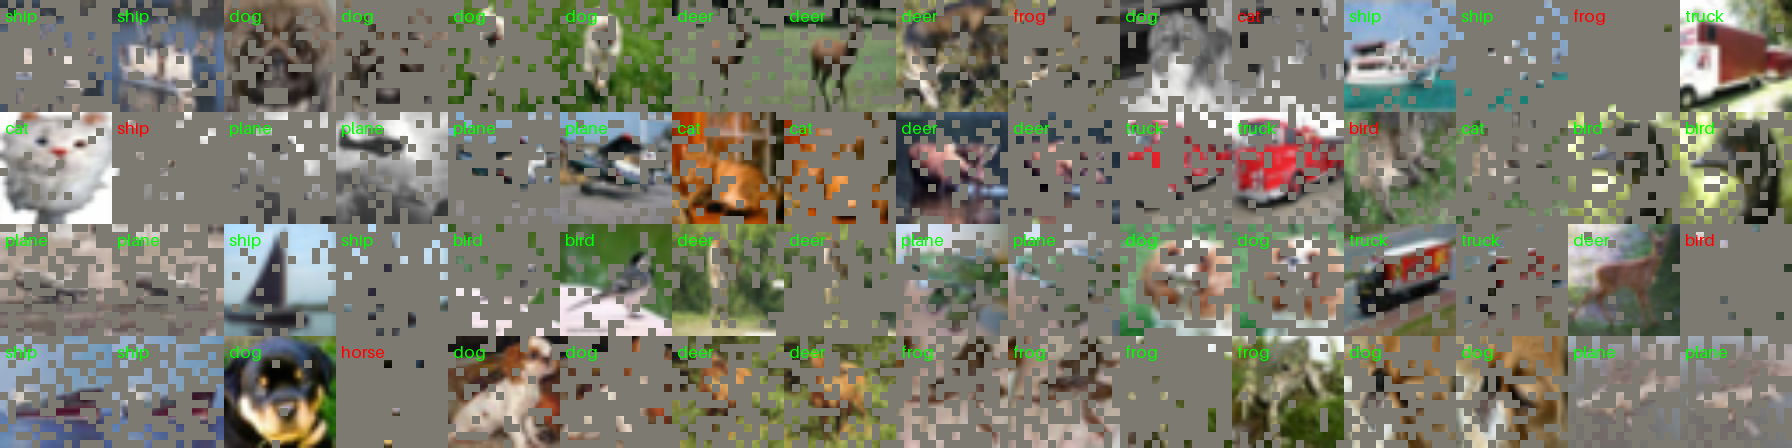

In [15]:
surrogate.eval()
logits = surrogate(images_masked.to(surrogate.device))
print(f'logits shape is {tuple(logits.shape)}')
preds = torch.argmax(logits, dim=1).cpu()
print(f'{preds.shape=}, {labels_masked.shape=}')
colors = [(0, 255, 0) if l == p else (255, 0, 0) for l, p in zip(labels_masked, preds)]
CIFAR_10_Dataset.to_image_grid(images_masked, preds, colors, scale=1/2, n_columns=n_masks_per_image * 8)

In [17]:
test_without_masks(surrogate, datamodule.test_dataloader())

Accuracy: 98.10%: 100%|██████████| 313/313 [00:16<00:00, 19.29it/s]


# Performance on masked images

In [18]:
def test_masked(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, device="cuda") -> None:
    results = []
    masked_percentages = []
    with torch.no_grad():
        model.to(device)
        correct, total = 0, 0
        progress = tqdm(dataloader)
        for d in progress:
            images, targets, masks = d['images'], d['labels'], d['masks']
            images, targets, masks = images.to(device), targets.to(device), masks.to(device)
            images, masks, targets = apply_masks_to_batch(images, masks, targets)
            logits = model(images)
            _, predicted = logits.max(dim=1)
            total += targets.shape[0]
            correct += predicted.eq(targets).sum().item()
            results.extend(predicted.eq(targets).cpu().numpy())
            masked_percentages.extend((1 - masks).to(torch.float).mean(dim=1).cpu().numpy() * 100)
            progress.set_description(f'Accuracy: {100.0 * correct / total:.2f}%')
    return pd.DataFrame({'result': results, 'masked %': masked_percentages})

all_results = {}

In [19]:
all_results["target"] = test_masked(target_model, datamodule.test_dataloader())

Accuracy: 68.52%: 100%|██████████| 313/313 [00:28<00:00, 11.10it/s]


In [20]:
all_results["surrogate"] = test_masked(surrogate, datamodule.test_dataloader())

Accuracy: 91.49%: 100%|██████████| 313/313 [00:28<00:00, 10.98it/s]


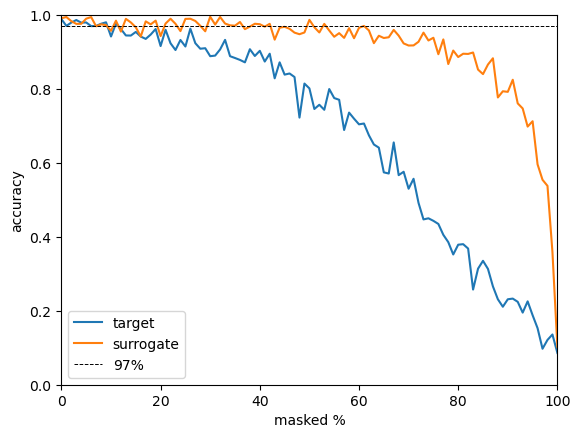

In [21]:
bucket_size = 1.0
for k, df in all_results.items():
    df['masked %'] = df['masked %'].div(bucket_size).round().astype(int).mul(bucket_size)

plt.figure()
for k, df in all_results.items():
    plt.plot(df.groupby('masked %').mean(), label=k)
plt.plot([0, 100], [0.97, 0.97], color='black', linestyle='dashed', linewidth=0.7, label='97%')
plt.legend()
plt.xlabel('masked %')
plt.ylabel('accuracy')
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.show()